# Aim

To replace AR2 modelling after a parameter estimation, this notebook uses a state-space model based on the usual vibration differential equation, following the method of chapter 5 in Zarchan and Musoff's book on Kalman filtering.

We start with the equation

$\ddot{x} + 2\zeta \omega \dot{x} + \omega^2 x = 0$

to which the solution is

$x = Ae^{-\zeta \omega t} \sin(\omega\sqrt{1 - \beta^2} t)$

where the parameters relate to those in our usual setup by $\zeta = k_i$ and $\omega = 2\pi f_i$.

This allows us to naturally define a continuous-time state-space model for a single vibration mode,

$F = \begin{bmatrix} \dot{x} \\ \ddot{x} \end{bmatrix} = \begin{bmatrix} 0 & 1 \\ -\omega_0^2 & -2\zeta \end{bmatrix} \begin{bmatrix} x \\ \dot{x} \end{bmatrix}$

which can be converted to discrete time either by matrix exponentiation or by a Laplace inverse. In the Laplace domain, the differential equation can be rewritten as

$s^2 + 2\zeta\omega s + \omega^2 = (s - (-\zeta\omega))^2 + (\omega\sqrt{1 - \zeta^2})^2$

Following the conventions of Zarchan and Musoff, let $a = -\zeta\omega$ and $b = \omega\sqrt{1 - \zeta^2}$. Then, by doing an inverse Laplace transform $\mathcal{L}^{-1}(sI - F)^{-1}$, we can get the discrete-time fundamental matrix as derived on page 209:

$A = \frac{1}{b}\begin{bmatrix} e^{a\Delta t} (-a \sin b\Delta t + b \cos b\Delta t) & e^{a\Delta t} \sin b\Delta t \\ (-\omega^2 e^{a\Delta t} \sin b\Delta t) & e^{a\Delta t} (a \sin b\Delta t + b\cos b\Delta t) \end{bmatrix}$

This can be easily augmented to incorporate many modes.

Note that amplitude and phase are left out of this derivation because they are completely specified by the initial system state.

In [1]:
# imports

import numpy as np
from scipy import optimize, signal, interpolate, stats
import matplotlib.pyplot as plt
import copy
%matplotlib inline

# global parameter definitions

f_sampling = 1000 # Hz
dt = 1/f_sampling # s; timestep
f_1 = f_sampling/60 # lowest possible frequency of a vibration mode
f_2 = f_sampling/3 # highest possible frequency of a vibration mode
f_w = f_sampling/3 # frequency above which measurement noise dominates
N_vib_app = 10 # number of vibration modes being applied
N_vib_max = 10 # number of vibration modes to be detected
energy_coeff = 1e-6 # proportion of total energy after which PSD curve fit ends
measurement_noise = 0.06 # milliarcseconds; pulled from previous notebook
time_id = 1 # timescale over which sysid runs. Pulled from Meimon 2010's suggested 1 Hz sysid frequency.

Max difference between SS and true is 1.3433698597964394e-14


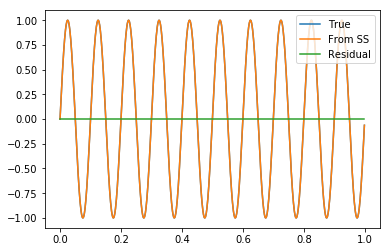

In [2]:
# first, no damping: check the DT SS model on a simple example.

times = np.arange(0, time_id, 1/f_sampling)

f_ud = 10
A_ud = 1
w_ud = 2*np.pi*f_ud
dx_undamped = A_ud * np.sin(w_ud*times)
dx_ud_r = np.zeros(times.size)
plt.plot(times, dx_undamped, label='True')

A = np.array([[np.cos(w_ud*dt), np.sin(w_ud*dt)/w_ud], [-w_ud*np.sin(w_ud*dt), np.cos(w_ud*dt)]])
state = np.array([0, w_ud]) # sin(w*0) and w cos(w*0)
k = 0
while k < int(time_id * f_sampling):
    dx_ud_r[k] = state[0]
    state = A.dot(state)
    k += 1
    
plt.plot(times, dx_ud_r, label='From SS')
plt.plot(times, dx_ud_r - dx_undamped, label='Residual')
plt.legend()

print("Max difference between SS and true is", np.max(np.abs(dx_ud_r - dx_undamped)))

[ 0.         62.83185307]
Max difference between SS and true is 0.00167370628242286


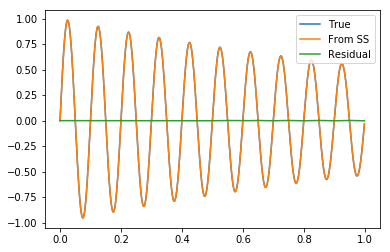

In [3]:
# next, do the same thing with a damping term

times = np.arange(0, time_id, 1/f_sampling)

f_d = 10
A_d = 1
w_d = 2*np.pi*f_d
k_d = 1e-2
dx_damped = A_d * np.sin(w_d*times) * np.exp(-k_d*w_d*times)
dx_d_r = np.zeros(times.size)
plt.plot(times, dx_damped, label='True')

a = -k_d * w_d
b = w_d * np.sqrt(1 - k_d**2)
coeff = np.exp(a*dt)/b
c, s = np.cos(b*dt), np.sin(b*dt)

A = coeff * np.array([[-a*s + b*c, s], [-w_d**2 * s, a*s + b*c]])
state = np.array([0, w_d]) # sin(w*0) and w cos(w*0) 
print(state)
k = 0
while k < int(time_id * f_sampling):
    dx_d_r[k] = state[0]
    state = A.dot(state)
    k += 1
    
plt.plot(times, dx_d_r, label='From SS')
plt.plot(times, dx_d_r - dx_damped, label='Residual')
plt.legend()

print("Max difference between SS and true is", np.max(np.abs(dx_d_r - dx_damped)))

Stdev of residual, x: 7.674649010959749e-05
Stdev of residual, y: 5.9557435358467924e-05


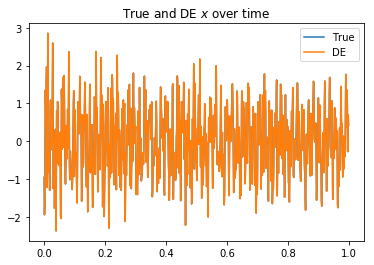

In [4]:
times = np.arange(0, time_id, 1/f_sampling)

vib_freqs = np.random.uniform(low=f_1, high=f_2, size=N_vib_app)  # Hz
vib_amps = np.random.uniform(low=0.1, high=1, size=N_vib_app) # milliarcseconds
vib_phase = np.random.uniform(low=0, high=2*np.pi, size=N_vib_app)  # radians
vib_pa = np.random.uniform(low=0, high=2*np.pi, size=N_vib_app)  # radians
vib_damping = np.random.uniform(low=1e-4, high=1e-3, size=N_vib_app) # unitless

dx = sum([-vib_amps[i]*np.sin(vib_pa[i])*np.sin(2*np.pi*vib_freqs[i]*times-vib_phase[i])
          *np.exp(-2*np.pi*vib_damping[i]*vib_freqs[i]*times) for i in range(N_vib_app)])
dy = sum([vib_amps[i]*np.cos(vib_pa[i])*np.sin(2*np.pi*vib_freqs[i]*times-vib_phase[i])
          *np.exp(-2*np.pi*vib_damping[i]*vib_freqs[i]*times) for i in range(N_vib_app)])

# construct the diffeq model based on exact parameters.
# since this is just numerically integrating the differential equation whose solution is in dx and dy,
# this should be entirely correct except for integration rounding errors, 
# which should be much smaller than measurement noise.

STATE_SIZE = 2*N_vib_max # since tip and tilt only differ in amplitudes, we can deal with both with one matrix
A = np.zeros((STATE_SIZE, STATE_SIZE))

for i in range(N_vib_max):
    k = vib_damping[i]
    f = vib_freqs[i]
    w = 2*np.pi*f
    a = -w*k
    b = w * np.sqrt(1 - k**2)
    c, s = np.cos(b*dt), np.sin(b*dt)
    coeff = np.exp(a*dt)/b
    A[2*i][2*i] = coeff*(-a*s + b*c)
    A[2*i][2*i+1] = coeff*s
    A[2*i+1][2*i] = -coeff * w**2 * s
    A[2*i+1][2*i+1] = coeff * (a*s + b*c)
    
# read an initial state.
# ideally you'd generate this from a combination of the process covariance and the initial noisy readings
# but here I'll just read off each one

x_state = np.zeros(STATE_SIZE)
y_state = np.zeros(STATE_SIZE)
for i in range(N_vib_max):
    x_state[2*i] = -vib_amps[i] * np.sin(vib_pa[i]) * np.sin(-vib_phase[i])
    x_state[2*i+1] = -vib_amps[i]*np.sin(vib_pa[i])*2*np.pi*vib_freqs[i]*(np.cos(-vib_phase[i]) - vib_damping[i]*np.sin(-vib_phase[i]))
    y_state[2*i] = vib_amps[i] * np.cos(vib_pa[i]) * np.sin(-vib_phase[i])
    y_state[2*i+1] = vib_amps[i]*np.cos(vib_pa[i])*2*np.pi*vib_freqs[i]*(np.cos(-vib_phase[i]) - vib_damping[i]*np.sin(-vib_phase[i]))
    
H = np.array([1, 0] * N_vib_max) # same H for x and y

t, k = 0, 0
dx_r, dy_r = np.zeros(int(f_sampling * time_id)), np.zeros(int(f_sampling * time_id))
while k < time_id * f_sampling:
    dx_r[k], dy_r[k] = H.dot(x_state), H.dot(y_state)
    x_state, y_state = A.dot(x_state), A.dot(y_state)
    k += 1
    t += dt
    
plt.plot(times, dx, label='True')
plt.plot(times, dx_r, label='DE')
plt.title("True and DE $x$ over time")
plt.legend()
print("Stdev of residual, x:", np.std(dx_r - dx))
print("Stdev of residual, y:", np.std(dy_r - dy))

Text(0.5,1,'Residual')

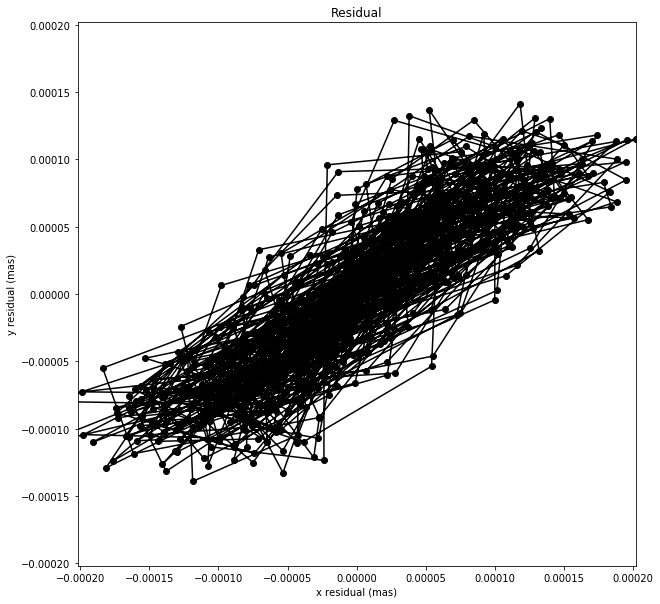

In [5]:
plt.figure(figsize=(10,10))
lim = max(np.max(dx - dx_r), np.max(dy - dy_r))
plt.xlim((-lim, lim))
plt.ylim((-lim, lim))
plt.plot(dx - dx_r, dy - dy_r, 'ko-')
plt.xlabel("x residual (mas)")
plt.ylabel("y residual (mas)")
plt.title("Residual")